# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [2]:
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np

In [3]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter=",")
    y = data[:, -1]
    x = data[:, 0:-1]
    return x, y.astype(int)

x_train, y_train = readucr("data/datos_train.csv")
x_test, y_test = readucr("data/datos_test.csv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [3]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [4]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [4]:
batch=64

In [16]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.3,
    dropout=0.20,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=batch,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
layer_normalization_16 (LayerNo (None, 4, 1)         2           input_2[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_8 (MultiHe (None, 4, 1)         14337       layer_normalization_16[0][0]     
                                                                 layer_normalization_16[0][0]     
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 4, 1)         0           multi_head_attention_8[0][0

[0.005264840088784695, 0.9978369474411011]

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


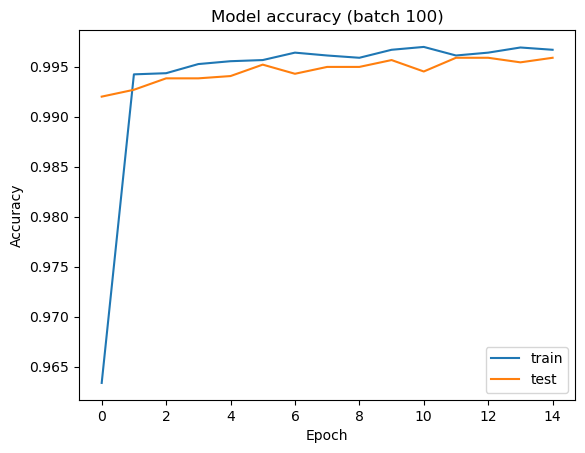

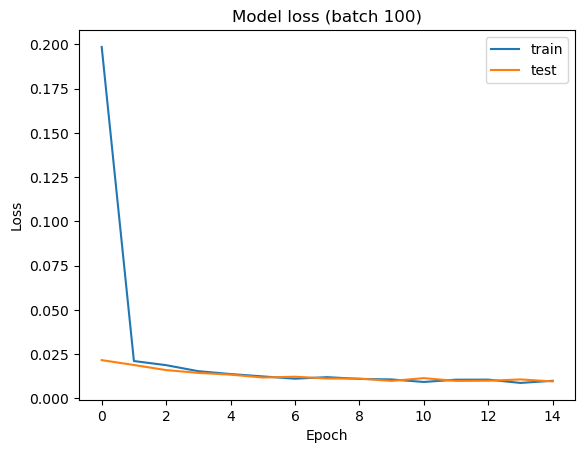

In [17]:

# list all data in history
print(history.history.keys())
# summarize history for sparse_categorical_accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy (batch {0})'.format(batch))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (batch {0})'.format(batch))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

In [20]:
model.save('../Models/binary_class_model_{0}.h5'.format(batch))

INFO:tensorflow:Assets written to: ./binary_class_model_100\assets


INFO:tensorflow:Assets written to: ./binary_class_model_100\assets


In [6]:
model = load_model(f'../Models/binary_class_model_{batch}.h5', compile = True)

In [7]:
use_samples = [
[0.0,0.0,0.0,0.0],
[2.4,0.0,0.0,0.0],
[0.0,0.1,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.1,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[1.2,0.0,0.1,0.0],
[2.9,29.9,2.3,0.1],
[3.1,37.6,2.1,1.1],
[1.4,2.2,0.2,0.2],
[0.0,0.1,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.2,0.0,0.0,0.0],
[0.0,0.0,0.1,0.0]
    ]

# Convert into Numpy array
samples_to_predict = np.array(use_samples)
print(samples_to_predict.shape)

# Generate predictions for samples
predictions = model.predict(samples_to_predict)
predictions_list = [predictions.flat[i] for i in range(1,len(predictions.flat),2)]
predictions_list

(24, 4)


[0.0006039598,
 0.0010924741,
 0.000599158,
 0.0006039598,
 0.0006039598,
 0.0005965056,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.0006039598,
 0.00067819597,
 0.9999995,
 1.0,
 0.0019529633,
 0.000599158,
 0.0006039598,
 0.0005924431,
 0.00060602743]

In [8]:
label_samples=[
'2019-06-30 00:00:00',
'2019-06-30 01:00:00',
'2019-06-30 02:00:00',
'2019-06-30 03:00:00',
'2019-06-30 04:00:00',
'2019-06-30 05:00:00',
'2019-06-30 06:00:00',
'2019-06-30 07:00:00',
'2019-06-30 08:00:00',
'2019-06-30 09:00:00',
'2019-06-30 10:00:00',
'2019-06-30 11:00:00',
'2019-06-30 12:00:00',
'2019-06-30 13:00:00',
'2019-06-30 14:00:00',
'2019-06-30 15:00:00',
'2019-06-30 16:00:00',
'2019-06-30 17:00:00',
'2019-06-30 18:00:00',
'2019-06-30 19:00:00',
'2019-06-30 20:00:00',
'2019-06-30 21:00:00',
'2019-06-30 22:00:00',
'2019-06-30 23:00:00']

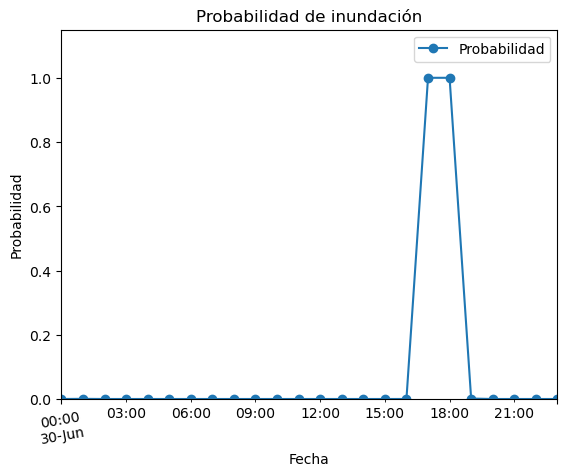

In [9]:
df=pd.DataFrame(list(zip(label_samples,predictions_list)),columns=['Fecha','Probabilidad'])
df["Fecha"]= pd.to_datetime(df["Fecha"])
df = df.set_index('Fecha')
df.plot(style="-o")
plt.title('Probabilidad de inundación')
plt.tick_params(axis='x', rotation=10)
plt.xlabel('Fecha')
plt.ylabel('Probabilidad')
plt.ylim([0,1.15])
plt.show()

In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

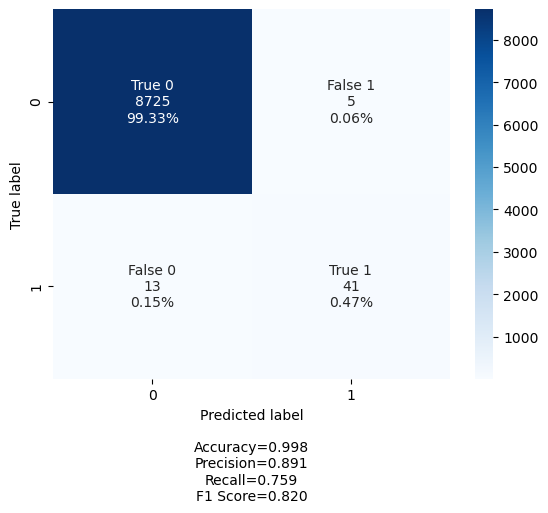

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predictions = model.predict(x_test)
predictions_list = [predictions.flat[i] for i in range(1,len(predictions.flat),2)]
predictions_list = np.around(predictions_list)
labels = ['True 0','False 1','False 0','True 1']
categories = ['0', '1']
make_confusion_matrix(confusion_matrix(y_test,predictions_list),cmap='Blues',group_names=labels,categories=categories)
plt.show()